In [32]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import riskfolio as rp

# Define the basket of stocks and benchmark
stocks = ["QYLG", "JEPQ", "PDI", "SVOL"]
benchmark = "SPY"

# Download historical price data for stocks and benchmark
data = yf.download(stocks + [benchmark], end="2024-01-01", progress=False, actions=True)


In [42]:
data = data.dropna(subset=[('Adj Close', stock) for stock in stocks + [benchmark]])

In [44]:

# Extract adjusted close prices and calculate returns
adj_close_prices = data['Adj Close']
stock_returns = adj_close_prices[stocks].pct_change().dropna()
benchmark_returns = adj_close_prices[benchmark].pct_change().dropna()


In [62]:
stock_returns

Ticker,QYLG,JEPQ,PDI,SVOL
Date,,,,
2022-05-06,-0.012467,-0.013432,-0.000872,0.000891
2022-05-09,-0.042464,-0.030278,-0.007420,-0.020507
2022-05-10,0.017180,0.007187,-0.001759,0.009583
2022-05-11,-0.030637,-0.024406,-0.020419,0.002699
2022-05-12,-0.001620,-0.004329,-0.025886,0.002692
...,...,...,...,...
2023-12-22,0.001385,0.000399,0.000000,0.000436
2023-12-26,0.004493,0.001794,0.003352,0.002122
2023-12-27,0.000000,0.001393,0.000557,0.004852


In [47]:
adj_close_prices

Ticker,JEPQ,PDI,QYLG,SPY,SVOL
Date,,,,,
2022-05-04,40.794914,16.703932,24.447447,414.551849,16.659456
2022-05-05,39.824844,16.516657,23.364403,399.817474,16.058853
2022-05-06,39.289906,16.502251,23.073124,397.431030,16.073160
2022-05-09,38.100281,16.379803,22.093353,384.706360,15.743542
2022-05-10,38.374126,16.350985,22.472908,385.595184,15.894409
...,...,...,...,...,...
2023-12-22,48.270981,16.704695,28.076103,470.664490,21.173622
2023-12-26,48.357594,16.760687,28.202263,472.651886,21.218550
2023-12-27,48.424957,16.770020,28.202263,473.506500,21.321508


In [57]:

# Download dividend data and calculate dividends for each stock
dividends = {stock: yf.Ticker(stock).dividends for stock in stocks}

# Adjust returns for dividends (assuming reinvested dividends for partial shares)
for stock in stocks:
    divs = dividends[stock]
    if not divs.empty:
        divs = divs.resample('D').sum().reindex(stock_returns.index).fillna(0)
        stock_returns[stock] = (adj_close_prices[stock] + divs).pct_change().dropna()

# Portfolio optimization using riskfolio-lib
stock_returns = stock_returns.dropna()
port = rp.Portfolio(returns=stock_returns.dropna())
method_mu = 'hist'  # Method to estimate expected returns based on historical data
method_cov = 'hist'  # Method to estimate covariance matrix based on historical data


In [58]:
port.assets_stats(method_mu=method_mu, method_cov=method_cov)


Optimized Portfolio Weights:
                 QYLG          JEPQ           PDI  SVOL
weights  2.586279e-10  3.138685e-10  1.617813e-10   1.0


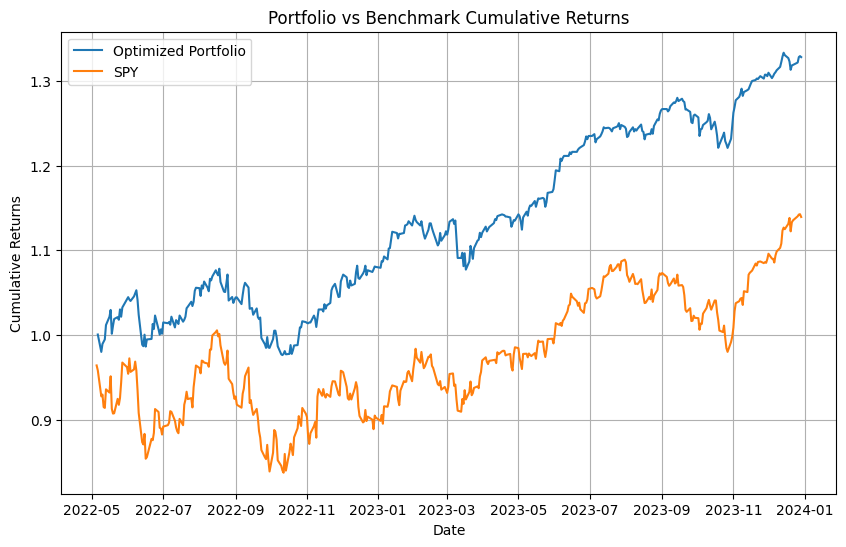

In [59]:

# Estimate the optimal weights for the portfolio
model = 'Classic'
rm = 'MV'  # Risk measure - Mean-Variance
obj = 'Sharpe'  # Objective function - Maximize Sharpe Ratio
hist = True  # Use historical data for the optimization
w = port.optimization(model=model, rm=rm, obj=obj, hist=hist)

# Display the optimized portfolio weights
print("Optimized Portfolio Weights:")
print(w.T)

# Compare portfolio performance against the benchmark
portfolio_returns = (stock_returns * w.T.values).sum(axis=1)
portfolio_cum_returns = (1 + portfolio_returns).cumprod()
benchmark_cum_returns = (1 + benchmark_returns).cumprod()

# Plot cumulative returns of the portfolio and benchmark
plt.figure(figsize=(10, 6))
plt.plot(portfolio_cum_returns, label='Optimized Portfolio')
plt.plot(benchmark_cum_returns, label=benchmark)
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.title('Portfolio vs Benchmark Cumulative Returns')
plt.legend()
plt.grid(True)
plt.show()


In [64]:
portfolio_cum_returns

Date
2022-05-06    1.000891
2022-05-09    0.980365
2022-05-10    0.989760
2022-05-11    0.992431
2022-05-12    0.995103
                ...   
2023-12-22    1.318502
2023-12-26    1.321299
2023-12-27    1.327711
2023-12-28    1.328876
2023-12-29    1.327711
Length: 415, dtype: float64